# Deep Learning Week 4: NLP Disaster Tweets Kaggle Mini-Project

## 1. Brief description of the problem and data

In this week assignment, we'll participate in the Kaggle [NLP Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started) Challenge. We'll address this challenge by building deep learning models to predict which tweets are about real disasters and which ones are not based on the tweet content. For this week assignment, we'll focus on RNN (Recurrent Neural Network) models.

We'll be using Natural Language Toolkit (NLTK) library ([https://www.nltk.org](https://www.nltk.org)) for NLP tasks such at text processing and text normalization. 

#### About the Dataset

We will be using the  Kaggle [NLP Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started) dataset. The dataset is provided subjected to Kaggle [Competition Rules](https://www.kaggle.com/competitions/nlp-getting-started/rules#7-competition-data).

**Files**

- train.csv - the training set
- test.csv - the test set
- sample_submission.csv - a sample submission file in the correct format

**Columns**

- id - a unique identifier for each tweet
- text - the text of the tweet
- location - the location the tweet was sent from (may be blank)
- keyword - a particular keyword from the tweet (may be blank)
- target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0).

#### Summary of Tasks:
- Load dataset
- Explore the dataset, perform data cleaning, data analysis, preprocess data
- Build and test models: Build, evaluate, and compare model's performances. 
- Summarize and discuss the results.

## 2. Exploratory Data Analysis (EDA) - Inspect, Visualize, and Clean the Data

In this section, We'll explore the dataset, perform data cleaning, data analysis, and text processing.

### 2.0. Import Libraries

In [1]:
#!pip3 install -U np pd matplotlib seaborn sklearn tensorflow keras_tuner nltk

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score
import tensorflow as tf
from tensorflow.keras import models, layers, callbacks, optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

### 2.1. Load Disaster Tweets Dataset

In [3]:
df_train_full = pd.read_csv('nlp-getting-started/train.csv')
df_test = pd.read_csv('nlp-getting-started/test.csv')

### 2.2. Explore the Dataset

In [4]:
df_train_full

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [5]:
print("Number of training samples:", df_train_full.shape[0])
print("Number of columns:", df_train_full.shape[1])

Number of training samples: 7613
Number of columns: 5


In [6]:
df_test

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [7]:
print("Number of test samples:", df_test.shape[0])
print("Number of columns:", df_test.shape[1])

Number of test samples: 3263
Number of columns: 4


In [8]:
# Set pd's display.max_colwidth to 'None' so that we can see full content
pd.set_option('display.max_colwidth', None)
df_train_full.sample(10)

,id,keyword,location,text,target
2461,3529,derailment,NaN,#???? #?? #??? #??? Trains derailment: 'It's the freakiest of freak accidents' - The Indian Express http://t.co/4Y4YtwhD74,1
1892,2723,crushed,ph,A diamond is just a piece of charcoal that handled stress exceptionally well. We are hard pressed on every side but not crushed.2 cor4:8,1
6029,8618,seismic,NaN,ON THE USE OF PERFORATED METAL SHEAR PANEL SFOR SEISMIC-RESISTANT APPLICATIONS http://t.co/cX5OjH2Dr4,0
2229,3188,deluge,NaN,Wrinkled the face of deluge as decayed;,0
1066,1538,bomb,keli x,HALSEY AND TROYE COLLAB WOULD BE BOMB,0
2542,3647,desolation,???????? ?????????.,My Chemical Romance ÛÓ Desolation Row #np,0
1737,2501,collided,NaN,Cyclist who collided with runner on Roanoke greenway wins $300000 civil verdict - Roanoke Times: Cyclist who c... http://t.co/E2WfGp8JHk,1
299,440,apocalypse,NaN,The latest from @BryanSinger reveals #Storm is a queen in #Apocalypse @RuPaul @AlexShipppp http://t.co/oQw8Jx6rTs,1
6108,8721,sinking,Liverpool,Do you feel like you are sinking in low self-image? Take the quiz: http://t.co/bJoJVM0pjX http://t.co/wHOc7LHb5F,1
5079,7242,natural%20disaster,Leitchfield Kentucky,What Natural Disaster Are You When You Get Angry? http://t.co/O9DzgZqEMf,0


### 2.3. Duplicate Entries and Null Values

In [9]:
# Check duplicate
print("Number of duplicate entries:", df_train_full.duplicated().sum())

Number of duplicate entries: 0


In [10]:
# Check null values
for col in df_train_full.columns:
    null_count = df_train_full[col].isnull().sum()
    percent = 100*null_count/len(df_train_full)
    print(f"Number of null values in colum '{col}': {null_count} ({percent:.2f}%)")

Number of null values in colum 'id': 0 (0.00%)
Number of null values in colum 'keyword': 61 (0.80%)
Number of null values in colum 'location': 2533 (33.27%)
Number of null values in colum 'text': 0 (0.00%)
Number of null values in colum 'target': 0 (0.00%)


In [11]:
# Check null values
for col in df_test.columns:
    null_count = df_test[col].isnull().sum()
    percent = 100*null_count/len(df_test)
    print(f"Number of null values in colum '{col}': {null_count} ({percent:.2f}%)")

Number of null values in colum 'id': 0 (0.00%)
Number of null values in colum 'keyword': 26 (0.80%)
Number of null values in colum 'location': 1105 (33.86%)
Number of null values in colum 'text': 0 (0.00%)


As we can see, about 33% of tweets are not associated with a location, 0.8% of tweets are not associated with a keyword. We'll drop 'location' column. And we'll fill missing keyword with 'unknown'.

In [12]:
df_train_full.drop(columns=['location'], inplace=True)
df_test.drop(columns=['location'], inplace=True)
df_train_full['keyword'] = df_train_full['keyword'].fillna('unknown')
df_test['keyword'] = df_test['keyword'].fillna('unknown')

In [13]:
df_train_full

,id,keyword,text,target
0,1,unknown,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,unknown,Forest fire near La Ronge Sask. Canada,1
2,5,unknown,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,unknown,"13,000 people receive #wildfires evacuation orders in California",1
4,7,unknown,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
...,...,...,...,...
7608,10869,unknown,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1
7609,10870,unknown,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1
7610,10871,unknown,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1
7611,10872,unknown,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1


### 2.4. Number of #Hashtag in a Tweet

In [14]:
# Return the number of #hagtag in a tweet
def count_hagtags(tweet):
    return len(re.findall(r'#\w+',tweet))

# Add hashtag column
df_train_full['hashtag'] = df_train_full['text'].apply(lambda tweet: count_hagtags(tweet))

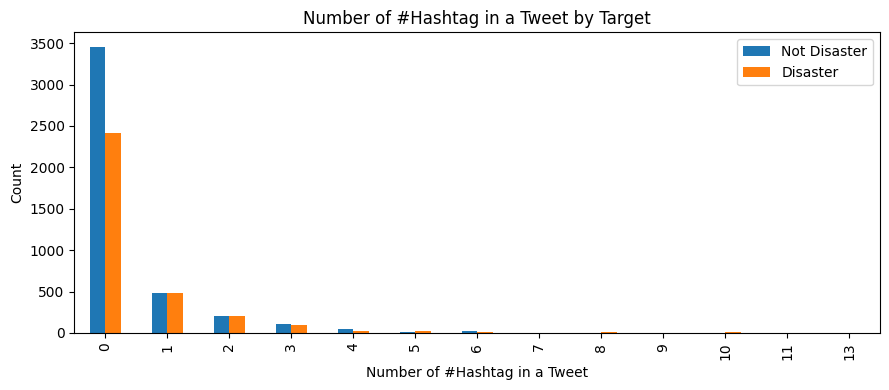

In [15]:
hashtag_vs_target_counts = df_train_full.groupby(['hashtag', 'target']).size().unstack()
_, ax = plt.subplots(figsize=(9, 4))
hashtag_vs_target_counts.plot(kind='bar', ax=ax)
plt.title('Number of #Hashtag in a Tweet by Target')
plt.legend(['Not Disaster', 'Disaster'])
plt.xlabel('Number of #Hashtag in a Tweet')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### 2.5. Number of @Mention in a Tweet

In [16]:
# Return the number of @mention in a tweet
def count_mentions(tweet):
    return len(re.findall(r'@\w+',tweet))

# Add hashtag column
df_train_full['mention'] = df_train_full['text'].apply(lambda tweet: count_mentions(tweet))


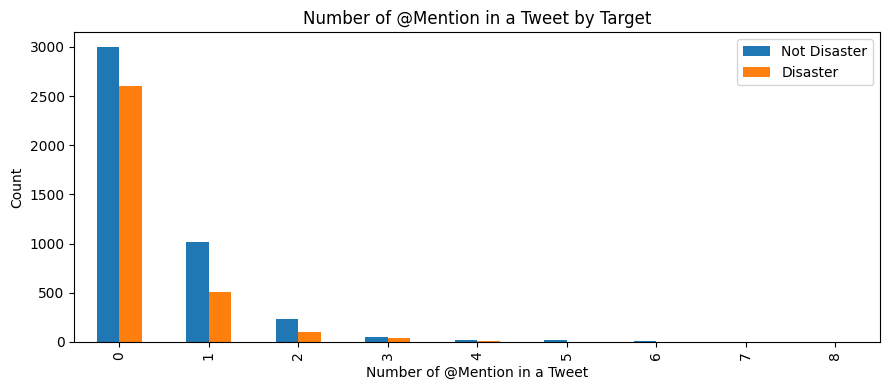

In [17]:
mention_vs_target_counts = df_train_full.groupby(['mention', 'target']).size().unstack()
_, ax = plt.subplots(figsize=(9, 4))
mention_vs_target_counts.plot(kind='bar', ax=ax)
plt.title('Number of @Mention in a Tweet by Target')
plt.legend(['Not Disaster', 'Disaster'])
plt.xlabel('Number of @Mention in a Tweet')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

### 2.6. Preprocess Text Data

We'll use Natural Language Toolkit (NLTK) library ([https://www.nltk.org](https://www.nltk.org)) for text processing and normalization. We'll remove @mentions, URLs, HTML tags, extra spaces, punctuations, numbers... from the tweets, and we'll apply lemmatization technique to reduce dimensionality and vocabulary size. **Lemmatization** is the process of reducing words to their base form (or lemma). It's a very first and crucial task in NLP. By consolidating different inflected forms of a word into a single lemma, lemmatization significantly reduces the number of unique words (tokens) in our text data, which can lead to more efficient model training, less memory consumption, better generalization, and improved accuracy.

In [18]:
# Install Natural Language Toolkit
# !pip3 install -U nltk

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Expand contradictions.
# This function is generated by Google Gemini ;)
def expand_contractions(text):
    """
    Expands common English contractions in a given text.
    """
    contractions_map = {
        "ain't": "am not",
        "aren't": "are not",
        "can't": "cannot",
        "can't've": "cannot have",
        "'cause": "because",
        "could've": "could have",
        "couldn't": "could not",
        "couldn't've": "could not have",
        "didn't": "did not",
        "doesn't": "does not",
        "don't": "do not",
        "hadn't": "had not",
        "hadn't've": "had not have",
        "hasn't": "has not",
        "haven't": "have not",
        "he'd": "he would",
        "he'd've": "he would have",
        "he'll": "he will",
        "he'll've": "he will have",
        "he's": "he is",
        "how'd": "how did",
        "how'd'y": "how do you",
        "how'll": "how will",
        "how's": "how is",
        "I'd": "I would",
        "I'd've": "I would have",
        "I'll": "I will",
        "I'll've": "I will have",
        "I'm": "I am",
        "I've": "I have",
        "isn't": "is not",
        "it'd": "it would",
        "it'd've": "it would have",
        "it'll": "it will",
        "it'll've": "it will have",
        "it's": "it is",
        "let's": "let us",
        "ma'am": "madam",
        "mayn't": "may not",
        "might've": "might have",
        "mightn't": "might not",
        "mightn't've": "might not have",
        "must've": "must have",
        "mustn't": "must not",
        "mustn't've": "must not have",
        "needn't": "need not",
        "needn't've": "need not have",
        "o'clock": "of the clock",
        "oughtn't": "ought not",
        "oughtn't've": "ought not have",
        "shan't": "shall not",
        "sha'n't": "shall not",
        "shan't've": "shall not have",
        "she'd": "she would",
        "she'd've": "she would have",
        "she'll": "she will",
        "she'll've": "she will have",
        "she's": "she is",
        "should've": "should have",
        "shouldn't": "should not",
        "shouldn't've": "should not have",
        "so've": "so have",
        "so's": "so is",
        "that'd": "that would",
        "that'd've": "that would have",
        "that's": "that is",
        "there'd": "there would",
        "there'd've": "there would have",
        "there's": "there is",
        "they'd": "they would",
        "they'd've": "they would have",
        "they'll": "they will",
        "they'll've": "they will have",
        "they're": "they are",
        "they've": "they have",
        "to've": "to have",
        "wasn't": "was not",
        "we'd": "we would",
        "we'd've": "we would have",
        "we'll": "we will",
        "we'll've": "we will have",
        "we're": "we are",
        "we've": "we have",
        "weren't": "were not",
        "what'll": "what will",
        "what'll've": "what will have",
        "what're": "what are",
        "what's": "what is",
        "what've": "what have",
        "when's": "when is",
        "when've": "when have",
        "where'd": "where did",
        "where's": "where is",
        "where've": "where have",
        "who'll": "who will",
        "who'll've": "who will have",
        "who's": "who is",
        "who've": "who have",
        "why's": "why is",
        "why've": "why have",
        "will've": "will have",
        "won't": "will not",
        "won't've": "will not have",
        "would've": "would have",
        "wouldn't": "would not",
        "wouldn't've": "would not have",
        "y'all": "you all",
        "y'all'd": "you all would",
        "y'all'd've": "you all would have",
        "y'all're": "you all are",
        "y'all've": "you all have",
        "you'd": "you would",
        "you'd've": "you would have",
        "you'll": "you will",
        "you'll've": "you will have",
        "you're": "you are",
        "you've": "you have"
    }

    # Create a regex pattern to find all contractions in the text
    # This ensures we match full words and handle cases with punctuation correctly
    contractions_pattern = re.compile('({})'.format('|'.join(re.escape(key) for key in contractions_map.keys())),
                                      flags=re.IGNORECASE | re.DOTALL)

    def replace_contraction(match):
        contraction = match.group(0)
        expanded_form = contractions_map.get(contraction.lower())
        if expanded_form:
            # Preserve the case of the first letter if the contraction was capitalized
            if contraction[0].isupper():
                return expanded_form.capitalize()
            return expanded_form
        return contraction

    expanded_text = contractions_pattern.sub(replace_contraction, text)
    
    return expanded_text

class TextProcessing():
    def __init__(self):
        # create wordnet lemmatizer object
        self.lemmatizer = WordNetLemmatizer()
        
    def lemmatize(self, text):
        words = [self.lemmatizer.lemmatize(word) for word in word_tokenize(text) if word not in stopwords.words('english')]
        return ' '.join(words)
        
    def process_text(self, text):
        # to lower cases
        text = text.lower()
        # convert %20 -> space
        text = text.replace('%20',' ')
        # expand contractions 
        text = expand_contractions(text) 
        # remove url
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        # remove HTML tag
        text = re.sub(r'<.*?>', '', text)
        # remove numbers
        text = re.sub(r'\w*\d\w*', '', text)
        # remove mentions
        text = re.sub(r'@\S+', '', text)
        # remove punctuations
        text = text.translate(str.maketrans('', '', string.punctuation))
        # remove extra spaces
        text = re.sub(r'\s+', ' ', text)
        return self.lemmatize(text)
        
tp = TextProcessing()

df_train_full['clean_text'] = df_train_full['text'].apply(tp.process_text)
df_train_full['clean_keyword'] = df_train_full['keyword'].apply(tp.process_text)
df_test['clean_text'] = df_test['text'].apply(tp.process_text)
df_test['clean_keyword'] = df_test['keyword'].apply(tp.process_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dongnguyen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
df_train_full.sample(10)

,id,keyword,text,target,hashtag,mention,clean_text,clean_keyword
5659,8071,rescue,Last Chance Animal Rescue has 3 new posts. http://t.co/f1tcbg1MKi #animalrescue | https://t.co/Is2iDC3UBJ,0,1,0,last chance animal rescue new post animalrescue,rescue
1777,2552,collision,Sometimes in space celestial bodies with separate trajectories that intertwine find themselves in a dance rather than a collision course.,0,0,0,sometimes space celestial body separate trajectory intertwine find dance rather collision course,collision
3156,4530,emergency,Gonna call up tomorrow with the aul 'emergency dental appointment' excuse just like the whole tooth falling out incident of last year,1,0,0,gon na call tomorrow aul emergency dental appointment excuse like whole tooth falling incident last year,emergency
6500,9293,survive,Parental experience may help coral offspring survive climate change: Preconditioning adult corals to increased... http://t.co/N9c3i9v8gO,0,0,0,parental experience may help coral offspring survive climate change preconditioning adult coral increased,survive
6750,9670,tornado,Second tornado confirmed in SundayÛªs storm http://t.co/Ffnzit7kgN,1,0,0,second tornado confirmed sundayûªs storm,tornado
809,1175,blight,Article by Michael Jackman at Metro Times Detroit:\nThe group later downgraded the estimate to 37 square miles of... http://t.co/h31mmuduqt,0,0,0,article michael jackman metro time detroit group later downgraded estimate square mile,blight
1426,2058,casualties,Whimsy as it pertains to mass casualties. Always impressive.,0,0,0,whimsy pertains mass casualty always impressive,casualty
569,822,battle,STAR WARS POWER OF THE JEDI COLLECTION 1 BATTLE DROID HASBRO - Full read by eBay http://t.co/yI30ZgiZsW http://t.co/2jGVhw7YZs,0,0,0,star war power jedi collection battle droid hasbro full read ebay,battle
1820,2616,crashed,@_rosewell it has crashed so many times the past couple hours,0,0,1,crashed many time past couple hour,crashed
284,415,apocalypse,RT: fittscott: Minecraft- NIGHT LUCKY BLOCK MOD (BOB APOCALYPSE WITHER 2.0 &amp; MORE!) Mod Showcase Popularmmos: http://t.co/MuL1J9AEUx viÛ_,0,0,0,rt fittscott minecraft night lucky block mod bob apocalypse wither amp mod showcase popularmmos viû,apocalypse


In [20]:
df_test.sample(10)

,id,keyword,text,clean_text,clean_keyword
2976,9845,trauma,Your brain is particularly vulnerable to trauma at two distinct ages http://t.co/Wvq0Rf6UAm,brain particularly vulnerable trauma two distinct age,trauma
2404,8048,refugees,Newlyweds feed Syrian refugees at their wedding http://t.co/DGjBuGxH9E #changetheworld #SyrianRefugees,newlywed feed syrian refugee wedding changetheworld syrianrefugees,refugee
1037,3407,derail,@Hajirah_ GM! I pray any attack of the enemy 2 derail ur destiny is blocked by the Lord &amp; that He floods ur life w/heavenly Blessings,gm pray attack enemy derail ur destiny blocked lord amp flood ur life wheavenly blessing,derail
1444,4792,evacuated,Family evacuated after weather bomb http://t.co/2A4z8pmvVE,family evacuated weather bomb,evacuated
1327,4380,earthquake,5.3 #Earthquake in South Of Fiji Islands. #iPhone users download the Earthquake app for more information http://t.co/V3aZWOAmzK,earthquake south fiji island iphone user download earthquake app information,earthquake
2179,7293,nuclear%20disaster,@Lacci Yes it's a disaster. To shut down all nuclear power plants would be to reverse ALL the gains from renewables so far.,yes disaster shut nuclear power plant would reverse gain renewables far,nuclear disaster
776,2562,crash,No citation for Billings police officer who caused Broadwater crash http://t.co/aAhYoEITzl http://t.co/ULZ3ubQV5z,citation billing police officer caused broadwater crash,crash
2991,9893,traumatised,@lisajdavidson1 @Nataliealana87 @WestEndShiv I'm already traumatised by my first full day at the Fringe,im already traumatised first full day fringe,traumatised
2764,9190,suicide%20bomber,IS claims suicide bombing against Saudi police: An Islamic State group suicide bomber on Thursday detona... http://t.co/yoXZFbRvzI #news,claim suicide bombing saudi police islamic state group suicide bomber thursday detona news,suicide bomber
449,1442,body%20bagging,Drake is really body bagging meek atm,drake really body bagging meek atm,body bagging


Now we have completed removing links, HMTL tags, @mentions, #hagtags, punctuations, common stopwords. We have also reduced words to their base or dictionary form (or lemma) by applying lemmatization technique. We can see that the 'cleaned' text is much shorter than the original text.

### 2.7. Length of Tweets

In [21]:
# Add wordcount column
df_train_full['wordcount'] = df_train_full['clean_text'].apply(lambda s: len(s.split()))

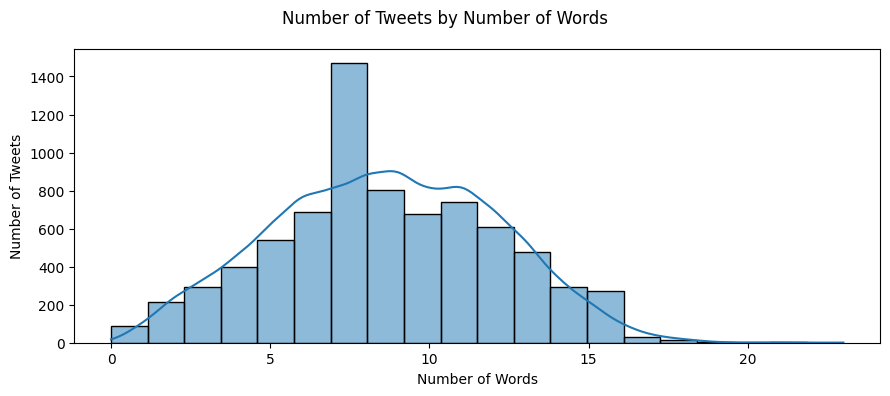

In [22]:
# Plot the Number of Tweets by Number of Words
fig, ax = plt.subplots(figsize=(9, 4))
fig.suptitle('Number of Tweets by Number of Words')
sns.histplot(df_train_full, x='wordcount', kde=True, bins=20, ax=ax)
ax.set(xlabel='Number of Words', ylabel="Number of Tweets")
plt.tight_layout()
plt.show()

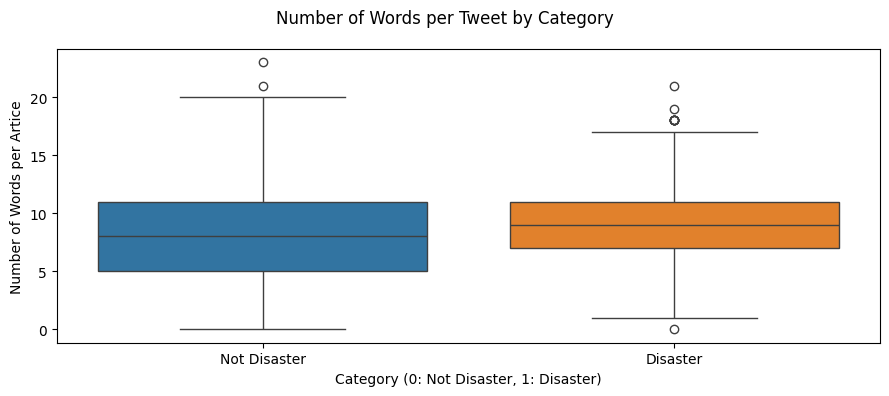

In [23]:
# Plot Number of Words per Tweet by Category
fig, ax = plt.subplots(figsize=(9, 4))
fig.suptitle('Number of Words per Tweet by Category')
sns.boxplot(ax=ax, data=df_train_full, x='target', y='wordcount', hue='target', legend=False)
ax.set(ylabel='Number of Words per Artice', xlabel='Category (0: Not Disaster, 1: Disaster)')
plt.xticks([0, 1], ['Not Disaster', 'Disaster'])
plt.tight_layout()
plt.show()

As we can see from the bar and box graphs above, the majority of tweets has 5 to 12 words. The box plot shows that the length of a tweet does not correlate with the target, a short or long tweet does not indicate whether it is associated with a real disaster or not.

### 2.8. Top Keywords

Now let's see what are the top keywords associated with real disasters.

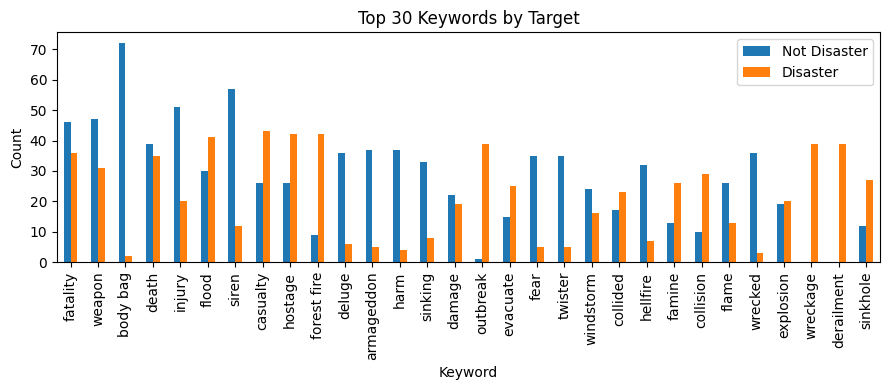

In [24]:
keyword_vs_target_counts = df_train_full[df_train_full['clean_keyword'] != 'unknown'].groupby(['clean_keyword', 'target']).size().unstack()
top_keywords = keyword_vs_target_counts.sum(axis=1).sort_values(ascending=False).head(30).index
_, ax = plt.subplots(figsize=(9, 4))
keyword_vs_target_counts.loc[top_keywords].plot(kind='bar', ax=ax)
plt.title('Top 30 Keywords by Target')
plt.legend(['Not Disaster', 'Disaster'])
plt.xlabel('Keyword')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Here we can see words like *wreckage, derailment, outbreak, forest fire, collision* are often associated with real disasters while words like *harm, fear, wrecked, siren, body bag* are often associated with false disasters.

### 2.9. Correlation Heatmap

Now we want to see if there is any correlation between the number of hashtags in a tweet, the number of mentions in a tweet, or the length of a tweet with the target.

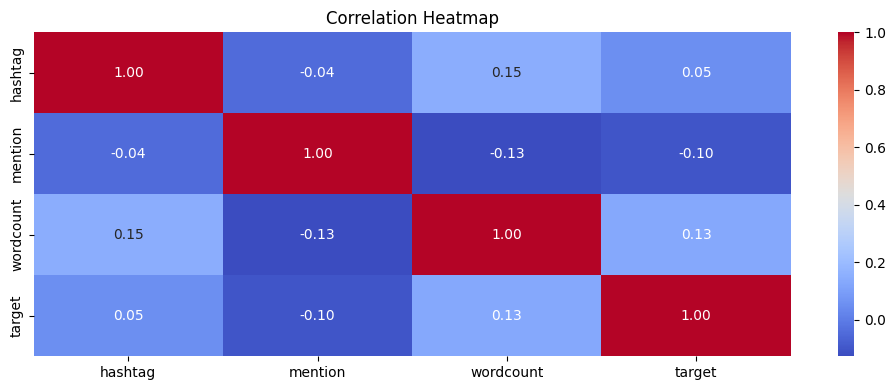

In [25]:
# Select numerical columns and display the correlation heatmap
df = df_train_full[['hashtag', 'mention', 'wordcount', 'target']]
#df = df_train_full.select_dtypes(include=[np.number])
plt.figure(figsize=(10, 4))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

The correlation heatmap indicates that there is no (or very weak) correlation between the number of hashtags, number of mentions or the length of a tweet with the target. So we will ignore these features.

### 2.10. Target Distribution

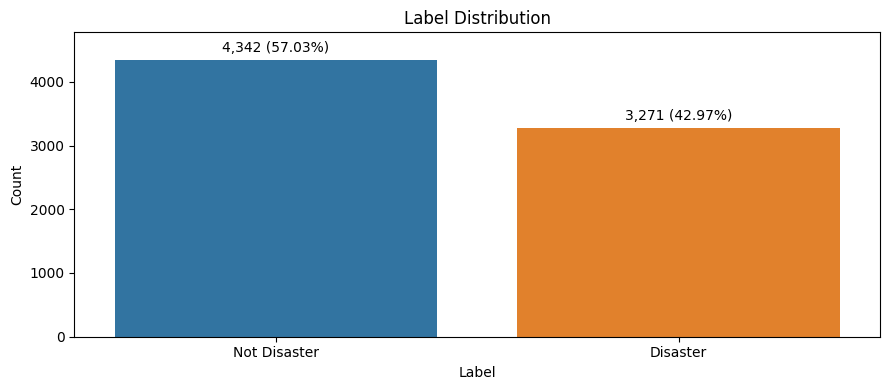

In [26]:
# Display label distribution
labels, counts = np.unique(df_train_full['target'], return_counts=True)
n_labels = counts.sum()
plt.figure(figsize=(9,4))
ax = sns.countplot(data=df_train_full, x='target', hue='target', legend=None)
for p in ax.patches:
    count = p.get_height()
    percent = 100 * count / n_labels
    ptitle = f'{count:,.0f} ({percent:.2f}%)'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.text(x, y + n_labels/100, ptitle, ha='center', va='bottom', fontsize=10)
plt.title("Label Distribution")
plt.xticks([0, 1], ['Not Disaster', 'Disaster'])
plt.xlabel("Label")
plt.ylabel("Count")
plt.ylim(0, counts.max() * 1.1)
plt.tight_layout()
plt.show()

The label distribution shows that our dataset is just slightly imbalanced.

## 3. RNN Models

We're going to addresses this challenge by building a deep learning model that can detect whether a tweet is about a real disaster (1) or not (0) base on the associated keyword and the tweet content using recurrent neural networks (RNN). We'll try Vanilla RNN, Gated Recurrent Unit (GRU) and Short-Term Memory (LSTM) models.

### 3.1. Helper Functions

In [27]:
# Build RNN model
def build_rnn_model(name, input_shape, input_dim, output_dim, units, model_type='simple', regularizer=None, dropout=0.0, recurrent_dropout=0.0):
    # Input layers
    text_input = layers.Input(shape=input_shape, name='text_input')
    keyword_input = layers.Input(shape=input_shape, name='keyword_input')
    # Embbeding layers
    text_embedding = layers.Embedding(input_dim=input_dim, 
                                      output_dim=output_dim,
                                      name='text_embedding')(text_input)
    keyword_embedding = layers.Embedding(input_dim=input_dim,
                                         output_dim=output_dim, 
                                         name='keyword_embedding')(keyword_input)
    # Concatenation of Embedded Inputs
    text_keyword_embedding = layers.Concatenate(axis=-1, name='text_keyword_embedding')([text_embedding, keyword_embedding])
    # Recurrent layers
    if model_type=='gru':
        rnn_output = layers.GRU(
            units=units, 
            name='GRU',
            dropout=dropout, 
            recurrent_dropout=recurrent_dropout,
            kernel_regularizer=regularizer,
            recurrent_regularizer=regularizer,
            bias_regularizer=regularizer
        )(text_keyword_embedding)
    elif model_type=='lstm':
        rnn_output = layers.LSTM(
            units=units, 
            name='LSTM',
            dropout=dropout, 
            recurrent_dropout=recurrent_dropout,
            kernel_regularizer=regularizer,
            recurrent_regularizer=regularizer,
            bias_regularizer=regularizer
        )(text_keyword_embedding)
    else: 
        # Simple RNN
        rnn_output = layers.SimpleRNN(
            units=units, 
            name='rnn_layer',
            dropout=dropout, 
            recurrent_dropout=recurrent_dropout,
            kernel_regularizer=regularizer,
            recurrent_regularizer=regularizer,
            bias_regularizer=regularizer
        )(text_keyword_embedding)
    # Output layer
    output = layers.Dense(1, activation='sigmoid', name='output')(rnn_output)
    
    # return model
    return models.Model(name=name, inputs=[text_input, keyword_input], outputs=output)

# Compile & fit
def compile_and_fit(model, tfds_train, tfds_val, num_epochs, batch_size, lr=1e-3, verbose=1):
    # Setup callbacks
    model_cbs = [
        # Stop training if performance doesn't improve
        callbacks.EarlyStopping(
            monitor='val_loss', 
            patience=5, 
            restore_best_weights=True, 
            verbose=verbose
        ),
        # Reduce learning rate on plateau
        callbacks.ReduceLROnPlateau(
            monitor='val_loss', 
            patience=2, 
            factor=0.2, 
            min_lr=1e-6,
            verbose=verbose
        ),
        # Save best model
        callbacks.ModelCheckpoint(
            filepath=f'{model.name}.keras',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=verbose
        )
    ]
    
    # Complie model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr), 
        loss='binary_crossentropy', 
        metrics=['accuracy']
    )

    # Fit model
    history = model.fit(
        tfds_train,
        epochs=num_epochs,
        validation_data=tfds_val,
        callbacks=model_cbs,
        batch_size=batch_size,
        verbose=verbose
    )
    return history

# Plot model traning history & validation results
def plot_model_history(training_history):
    model_hist = training_history.history
    epochs = [epoch+1 for epoch in training_history.epoch]

    plt.figure(figsize=(9, 4))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, model_hist['loss'], label='Train Loss')
    plt.plot(epochs, model_hist['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid()
    plt.legend(loc='lower left')
    plt.legend()
    
    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, model_hist['accuracy'], label='Train Accuracy')
    plt.plot(epochs, model_hist['val_accuracy'], label='Val Accuracy')
    #plt.ylim(0.5,1.05)
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.legend(loc='lower right')
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix_result(y_true, y_pred, labels=['0', '1'], dataset='Training'):
    plt.figure(figsize=(9, 6))
    cm = confusion_matrix(y_true, y_pred)
    ax = sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap=plt.cm.Blues,
        xticklabels=labels,
        yticklabels=labels
    )
    plt.title(f'Confusion Matrix on {dataset} Dataset')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    ax.xaxis.tick_top()
    plt.tight_layout()
    plt.show()

# Create Kaggle submission
def create_submission(model, X_test, X_test_id, batch_size, print_samples=True):
    # Create submission
    y_test_prob = model.predict(X_test, batch_size=batch_size, verbose=1)
    y_test_pred = (y_test_prob >= 0.5).astype(int).flatten()
    submission_df = pd.DataFrame({'id': X_test_id,'target': y_test_pred})
    filename = 'submission-' + model.name + '.csv'
    submission_df.to_csv(filename, index=False)
    # Print submission samples
    if print_samples:
        print(f"\nSubmission file: {filename}\n")
        print(f"Sample of submission content:\n{submission_df.head()}")

# used to store model performance data
performance_data = {
    'model': [],
    'train_time': [],
    'train_epoch': [],
    'val_accuracy': [],
    'val_f1_score': [],
    'test_score': [],
}

### 3.2. Prepare Data for Training and Validation

**Split Data into Training and Validation Sets**

In [28]:
TEST_SIZE = 0.2 # training: 80%, validation: 20%
df_train, df_val = train_test_split(
    df_train_full, test_size=TEST_SIZE, random_state=42, stratify=df_train_full['target']
)
train_text, val_text = df_train['clean_text'].to_list(), df_val['clean_text'].to_list()
train_keyword, val_keyword = df_train['clean_keyword'].to_list(), df_val['clean_keyword'].to_list()
y_train, y_val = df_train['target'].to_list(), df_val['target'].to_list()
test_text = df_test['clean_text'].to_list()
test_keyword = df_test['clean_keyword'].to_list()

**Tokenize and Pad Sequences**

Tokenization and Padding Sequences are two fundamental and often sequential steps in preparing text data for machine learning models, especially deep learning models like RNNs. Tokenization is the first step in converting human-readable text into a numerical representation that a machine learning model can process. Padding sequences is the process of making all input sequences (which are now numerical sequences from tokenization) the same length.

In [29]:
num_words = 10000 # max words in vocab

# Build the vocabulary from the tweets
tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
tokenizer.fit_on_texts(
    train_text + train_keyword + val_text + val_keyword
)
print('Number of vocabulary words:', num_words)

# Convert text to sequences
train_text_sequences = tokenizer.texts_to_sequences(train_text)
val_text_sequences = tokenizer.texts_to_sequences(val_text)
test_text_sequences = tokenizer.texts_to_sequences(test_text)
train_keyword_sequences = tokenizer.texts_to_sequences(train_keyword)
val_keyword_sequences = tokenizer.texts_to_sequences(val_keyword)
test_keyword_sequences = tokenizer.texts_to_sequences(test_keyword)

# Make all sequences the same length by padding
max_sequence_length = max(
    max(len(seq) for seq in train_text_sequences),
    max(len(seq) for seq in val_text_sequences),
    max(len(seq) for seq in test_text_sequences),
    max(len(seq) for seq in train_keyword_sequences),
    max(len(seq) for seq in val_keyword_sequences),
    max(len(seq) for seq in test_keyword_sequences)
)
print(f"Longest text sequence length: {max_sequence_length}")

X_train_text_seq = pad_sequences(train_text_sequences, maxlen=max_sequence_length)
X_val_text_seq = pad_sequences(val_text_sequences, maxlen=max_sequence_length)
X_test_text_seq = pad_sequences(test_text_sequences, maxlen=max_sequence_length)
X_train_keyword_seq = pad_sequences(train_keyword_sequences, maxlen=max_sequence_length)
X_val_keyword_seq = pad_sequences(val_keyword_sequences, maxlen=max_sequence_length)
X_test_keyword_seq = pad_sequences(test_keyword_sequences, maxlen=max_sequence_length)

Number of vocabulary words: 10000
Longest text sequence length: 23


**Create TensorFlow Datasets**

A tf.data.Dataset represents a sequence of elements, where each element can itself be composed of one or more TensorFlow tensors. it brings significant advantages, especially when dealing with large datasets or complex preprocessing. The chainable APIs such as shuffle, batch, prefetch make it very intuitive to build complex and efficient data pipelines in TensorFlow

In [30]:
# Check tensorflow version & GPU support
print("Tensorflow version " + tf.__version__)
print(f"tf.keras version: {tf.keras.__version__}")
physical_devices = tf.config.list_physical_devices('GPU')

# Set batch size
BATCH_SIZE = 32
TRAIN_EPOCHS = 10
if len(physical_devices) > 0:
    print(physical_devices)
    BATCH_SIZE = 128
    TRAIN_EPOCHS = 30
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
else:
    print("No GPU available!")

# Set random seed
RANDOM_SEED = 42
tf.random.set_seed(RANDOM_SEED)

print(f'\nBatch size: {BATCH_SIZE}')
print(f'Number of training epochs: {TRAIN_EPOCHS}')

Tensorflow version 2.19.0
tf.keras version: 3.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Batch size: 128
Number of training epochs: 30


In [31]:
# Create tensorflow training dataset
tfds_train = tf.data.Dataset.from_tensor_slices((
        {'text_input': X_train_text_seq, 'keyword_input': X_train_keyword_seq},
        y_train
)).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
# Create tensorflow validation dataset
tfds_val = tf.data.Dataset.from_tensor_slices((
        {'text_input': X_val_text_seq, 'keyword_input': X_val_keyword_seq},
        y_val
)).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
# Create tensorflow test dataset
tfds_test = tf.data.Dataset.from_tensor_slices((
    {'text_input': X_test_text_seq, 'keyword_input': X_test_keyword_seq}
)).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

2025-06-29 14:46:02.373019: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-06-29 14:46:02.373042: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-06-29 14:46:02.373046: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1751183162.373057   75117 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1751183162.373076   75117 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### 3.3. Simple RNN

Now let's try with a very simple RNN model

**Build Model**

In [32]:
# Build model
simple_rnn_model = build_rnn_model(name='simple-rnn', 
                                   input_shape=(max_sequence_length,), 
                                   input_dim=num_words,
                                   regularizer='l2',
                                   output_dim=64, 
                                   units=32)

# Print model summary
print("Simple RNN Model Summary:")
simple_rnn_model.summary()

Simple RNN Model Summary:


Model: "simple-rnn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keyword_input       │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_embedding      │ (None, 23, 64)    │    640,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keyword_embedding   │ (None, 23, 64)    │    640,000 │ keyword_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_keyword_embed… │ (None, 23, 128)   │          0 │ text_embedding[0… │
│ (Concatenate)       │                   │            │ keyword_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rnn_layer           │ (None, 32)        │      5,152 │ text_keyword_emb… │
│ (SimpleRNN)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         33 │ rnn_layer[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,285,185 (4.90 MB)

 Trainable params: 1,285,185 (4.90 MB)

 Non-trainable params: 0 (0.00 B)

**Train Model**

In [33]:
time0 = time.time()
simple_rnn_model_history = compile_and_fit(simple_rnn_model, tfds_train, tfds_val, TRAIN_EPOCHS, BATCH_SIZE, verbose=1)
time1 = time.time() - time0
print(f"Training time: {time1:.1f} seconds")

Epoch 1/30


2025-06-29 14:46:02.932120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
E0000 00:00:1751183162.935480   75117 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.6020 - loss: 1.4056
Epoch 1: val_accuracy improved from -inf to 0.74327, saving model to simple-rnn.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 328ms/step - accuracy: 0.6027 - loss: 1.4035 - val_accuracy: 0.7433 - val_loss: 1.0829 - learning_rate: 0.0010
Epoch 2/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.8077 - loss: 0.9533
Epoch 2: val_accuracy improved from 0.74327 to 0.81550, saving model to simple-rnn.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 316ms/step - accuracy: 0.8078 - loss: 0.9518 - val_accuracy: 0.8155 - val_loss: 0.7882 - learning_rate: 0.0010
Epoch 3/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.8907 - loss: 0.6274
Epoch 3: val_accuracy did not improve from 0.81550
48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 314ms/step - accuracy: 0.8908 - loss: 0.6268 - val_accuracy: 0.8037 - val_loss: 0.7449 - learning_rate: 0.0010
Epoch 4/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.9382 - loss: 0.4499
Epoch 4: val_ac

**Training History: Model Loss & Accuracy**

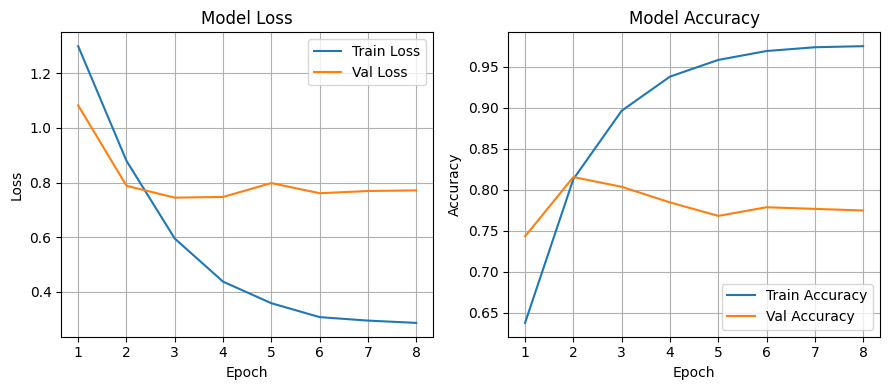

In [34]:
plot_model_history(simple_rnn_model_history)

From above graph, we can see that the training loss decreases initially but then increases and flattens out and shows little to no further improvement. This might indicate that the model is likely overfitting, vanishing gradient issue might occured.

**Classification Report & Confusion Matrix**

 3/12 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step 

E0000 00:00:1751183285.538629   75117 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step

Classification Report on Validation Dataset:
              precision    recall  f1-score   support

Not Disaster       0.79      0.91      0.85       869
    Disaster       0.86      0.68      0.76       654

    accuracy                           0.82      1523
   macro avg       0.83      0.80      0.81      1523
weighted avg       0.82      0.82      0.81      1523



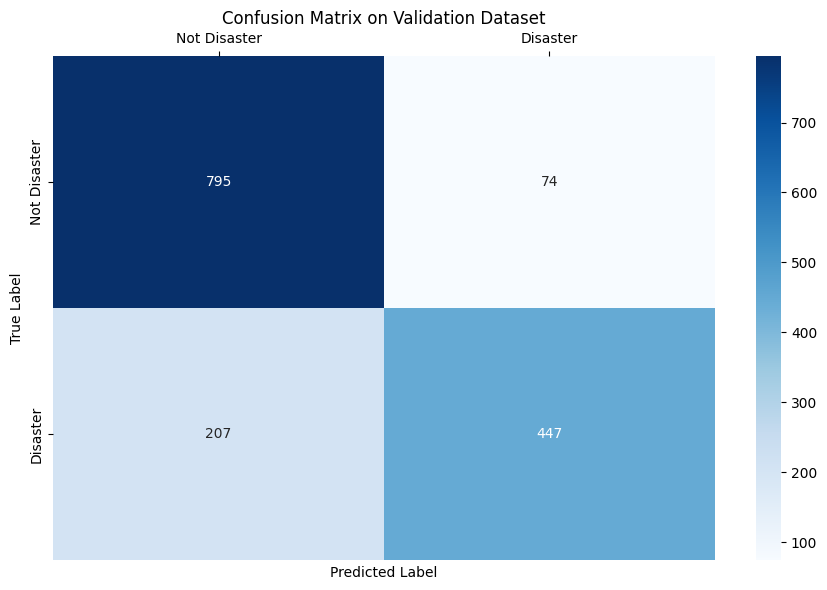

In [35]:
simple_rnn_model = models.load_model(f'{simple_rnn_model.name}.keras')
y_val_prob = simple_rnn_model.predict(tfds_val, batch_size=BATCH_SIZE, verbose=1)
y_val_pred = (y_val_prob >= 0.5).astype(int).flatten()
print("\nClassification Report on Validation Dataset:")
print(classification_report(y_val, y_val_pred, target_names=['Not Disaster', 'Disaster']))
# Plot confusion matrix result
plot_confusion_matrix_result(y_val, y_val_pred, labels=['Not Disaster', 'Disaster'], dataset='Validation')

**Submission & Test Results**

In [36]:
# Create submission
create_submission(simple_rnn_model, tfds_test, df_test['id'].values, batch_size=BATCH_SIZE)

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step

Submission file: submission-simple-rnn.csv

Sample of submission content:
   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1


Kaggle Public Score: 0.76984

In [37]:
# Collect model performance data
performance_data['model'].append('Simple RNN')
performance_data['train_time'].append(int(time1))
performance_data['train_epoch'].append(len(simple_rnn_model_history.epoch))
performance_data['val_accuracy'].append(accuracy_score(y_val, y_val_pred))
performance_data['val_f1_score'].append(f1_score(y_val, y_val_pred))

### 3.4. Gated Recurrent Unit (GRU)

**Build Model**

In [38]:
# Build model
gru_model = build_rnn_model(name='gru', 
                            model_type='gru',
                            input_shape=(max_sequence_length,), 
                            input_dim=num_words,
                            regularizer='l2',
                            output_dim=64, 
                            units=32)

# Print model summary
print("GRU Model Summary:")
gru_model.summary()

GRU Model Summary:


Model: "gru"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keyword_input       │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_embedding      │ (None, 23, 64)    │    640,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keyword_embedding   │ (None, 23, 64)    │    640,000 │ keyword_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_keyword_embed… │ (None, 23, 128)   │          0 │ text_embedding[0… │
│ (Concatenate)       │                   │            │ keyword_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GRU (GRU)           │ (None, 32)        │     15,552 │ text_keyword_emb… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         33 │ GRU[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,295,585 (4.94 MB)

 Trainable params: 1,295,585 (4.94 MB)

 Non-trainable params: 0 (0.00 B)

**Train Model**

In [39]:
time0 = time.time()
gru_model_history = compile_and_fit(gru_model, tfds_train, tfds_val, TRAIN_EPOCHS, BATCH_SIZE, verbose=1)
time1 = time.time() - time0
print(f"Training time: {time1:.1f} seconds")

Epoch 1/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.5775 - loss: 1.8293
Epoch 1: val_accuracy improved from -inf to 0.62902, saving model to gru.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.5775 - loss: 1.8247 - val_accuracy: 0.6290 - val_loss: 1.2004 - learning_rate: 0.0010
Epoch 2/30
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6813 - loss: 1.0617
Epoch 2: val_accuracy improved from 0.62902 to 0.79317, saving model to gru.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.6833 - loss: 1.0571 - val_accuracy: 0.7932 - val_loss: 0.7646 - learning_rate: 0.0010
Epoch 3/30
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8484 - loss: 0.6493
Epoch 3: val_accuracy improved from 0.79317 to 0.80630, saving model to gru.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.8483 - loss: 0.6471 - val_accuracy: 0.8063 - val_loss: 0.5838 - learning_rate: 0.0010
Epoch 4/30
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.8944 - loss: 0.42

**Training Results: Model Loss & Accuracy**

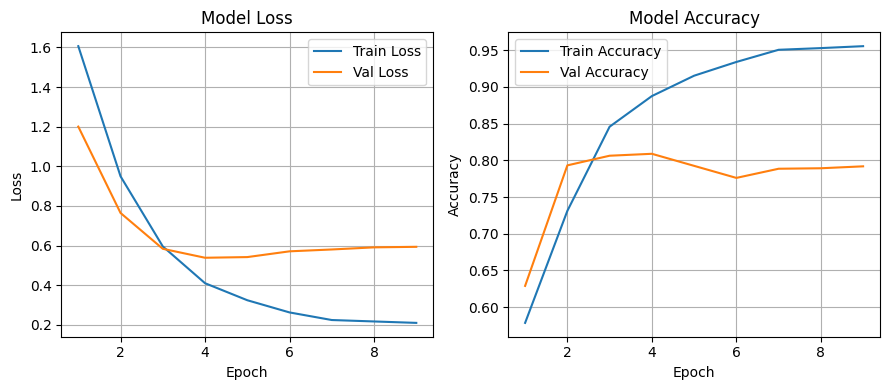

In [40]:
plot_model_history(gru_model_history)

Here we encounter the same issue as our previous model. From above graph, we can see that the training loss decreases initially but then increases and flattens out. The training stops after 9 epochs.

**Classification Report & Confusion Matrix**

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Classification Report:
              precision    recall  f1-score   support

Not Disaster       0.80      0.88      0.84       869
    Disaster       0.82      0.71      0.76       654

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523



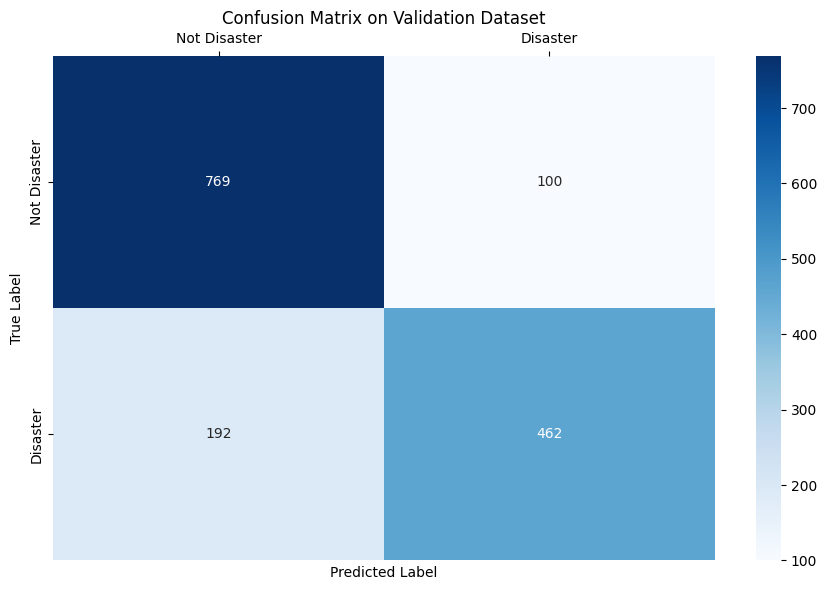

In [41]:

gru_model = models.load_model(f'{gru_model.name}.keras')
y_val_prob = gru_model.predict(tfds_val, batch_size=BATCH_SIZE, verbose=1)
y_val_pred = (y_val_prob >= 0.5).astype(int).flatten()
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, target_names=['Not Disaster', 'Disaster']))
# Plot confusion matrix result
plot_confusion_matrix_result(y_val, y_val_pred, labels=['Not Disaster', 'Disaster'], dataset='Validation')

**Submission & Test Results**

In [42]:
# Create kaggle submission
create_submission(gru_model, tfds_test, df_test['id'].values, batch_size=BATCH_SIZE)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Submission file: submission-gru.csv

Sample of submission content:
   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1


Kaggle Public Score: 0.78547

In [43]:
# Collect model performance data
performance_data['model'].append('GRU')
performance_data['train_time'].append(int(time1))
performance_data['train_epoch'].append(len(gru_model_history.epoch))
performance_data['val_accuracy'].append(accuracy_score(y_val, y_val_pred))
performance_data['val_f1_score'].append(f1_score(y_val, y_val_pred))

### 3.5. Long Short-Term Memory (LSTM)

**Build Model**

In [44]:
# Build model
lstm_model = build_rnn_model(name='lstm', 
                            model_type='lstm',
                            input_shape=(max_sequence_length,), 
                            input_dim=num_words,
                            regularizer='l2',
                            output_dim=64, 
                            units=32)

# Print model summary
print("LSTM Model Summary:")
lstm_model.summary()

LSTM Model Summary:


Model: "lstm"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keyword_input       │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_embedding      │ (None, 23, 64)    │    640,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keyword_embedding   │ (None, 23, 64)    │    640,000 │ keyword_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_keyword_embed… │ (None, 23, 128)   │          0 │ text_embedding[0… │
│ (Concatenate)       │                   │            │ keyword_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM (LSTM)         │ (None, 32)        │     20,608 │ text_keyword_emb… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         33 │ LSTM[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,300,641 (4.96 MB)

 Trainable params: 1,300,641 (4.96 MB)

 Non-trainable params: 0 (0.00 B)

**Train Model**

In [45]:
time0 = time.time()
lstm_model_history = compile_and_fit(lstm_model, tfds_train, tfds_val, TRAIN_EPOCHS, BATCH_SIZE, verbose=1)
time1 = time.time() - time0
print(f"Training time: {time1:.1f} seconds")

Epoch 1/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5600 - loss: 2.2861
Epoch 1: val_accuracy improved from -inf to 0.62114, saving model to lstm.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.5603 - loss: 2.2806 - val_accuracy: 0.6211 - val_loss: 1.5223 - learning_rate: 0.0010
Epoch 2/30
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7070 - loss: 1.3619
Epoch 2: val_accuracy improved from 0.62114 to 0.79645, saving model to lstm.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7088 - loss: 1.3565 - val_accuracy: 0.7965 - val_loss: 0.9997 - learning_rate: 0.0010
Epoch 3/30
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8546 - loss: 0.8678
Epoch 3: val_accuracy improved from 0.79645 to 0.80630, saving model to lstm.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.8545 - loss: 0.8668 - val_accuracy: 0.8063 - val_loss: 0.8098 - learning_rate: 0.0010
Epoch 4/30
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8923 - loss: 0

**Training Results: Model Loss & Accuracy**

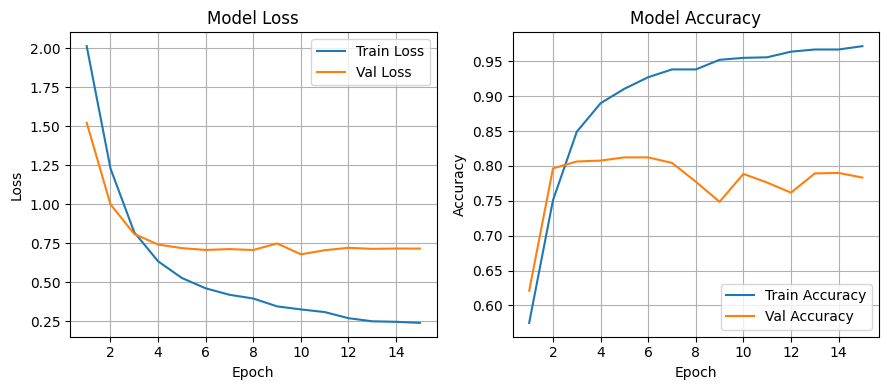

In [46]:
plot_model_history(lstm_model_history)

From the above graph we can see that LSTM is still struggling with the same problem. The loss during training initially decreases but then increases and flattens out. The training stops after 15 epochs.

**Classification Report & Confusion Matrix**

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

Classification Report:
              precision    recall  f1-score   support

Not Disaster       0.80      0.88      0.84       869
    Disaster       0.82      0.71      0.76       654

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523



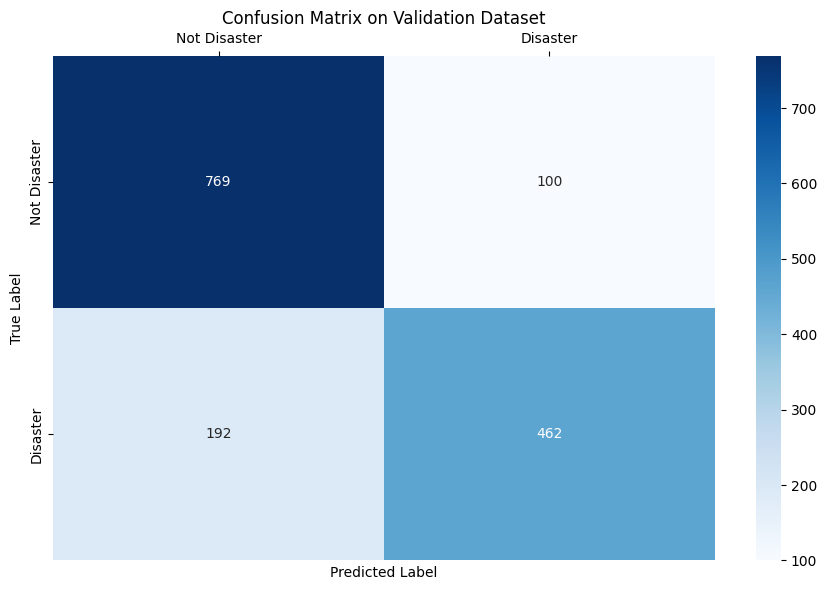

In [47]:

lstm_model = models.load_model(f'{lstm_model.name}.keras')
y_val_prob = gru_model.predict(tfds_val, batch_size=BATCH_SIZE, verbose=1)
y_val_pred = (y_val_prob >= 0.5).astype(int).flatten()
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred, target_names=['Not Disaster', 'Disaster']))
# Plot confusion matrix result
plot_confusion_matrix_result(y_val, y_val_pred, labels=['Not Disaster', 'Disaster'], dataset='Validation')

**Submission & Test Results**

In [48]:
# Create kaggle submission
create_submission(lstm_model, tfds_test, df_test['id'].values, batch_size=BATCH_SIZE)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Submission file: submission-lstm.csv

Sample of submission content:
   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1


Kaggle Public Score: 0.78547

In [49]:
# Collect model performance data
performance_data['model'].append('LSTM')
performance_data['train_time'].append(int(time1))
performance_data['train_epoch'].append(len(lstm_model_history.epoch))
performance_data['val_accuracy'].append(accuracy_score(y_val, y_val_pred))
performance_data['val_f1_score'].append(f1_score(y_val, y_val_pred))

### 3.6. RNN Tuning with Keras Tuner

Now let's fine tune our RNN model. We'll tune the following parameters:
- Model: GRU or LSTM
- Number of units: 32, 64 or 128
- Dropout/recurent dropout: 0.0 or 0.3
- Adam optimizer learning rate: 1e-3 or 1e-4

In [50]:
import keras_tuner as kt

def model_builder(hp):

   # Tuning hyperparameters
   hp_model = hp.Choice('model', values=['gru', 'lstm'])
   hp_units = hp.Choice('units', values=[32, 64, 128])
   hp_dropout = hp.Choice('dropout', values=[0.0, 0.3, 0.5])
   hp_lr = hp.Choice('learning_rate', values=[1e-3, 1e-4])
   
   # Build model
   model = build_rnn_model(name='rnn-tuner', model_type=hp_model, input_shape=(max_sequence_length,), 
                           input_dim=num_words, output_dim=64, units=hp_units, dropout=hp_dropout,
                           regularizer='l2')
   # Compile model
   model.compile(
      optimizer=optimizers.Adam(hp_lr),
      loss='binary_crossentropy',
      metrics=['accuracy']
   )
   return model

tuner = kt.GridSearch(hypermodel=model_builder, objective="val_accuracy")

# Setup callbacks
tuner_callbacks = [
   # Stop training if performance doesn't improve
   callbacks.EarlyStopping(
      monitor='val_loss', 
      patience=5, 
      restore_best_weights=True, 
      verbose=1
   ),
   # Reduce learning rate on plateau
   callbacks.ReduceLROnPlateau(
      monitor='val_loss', 
      patience=2, 
      factor=0.2, 
      min_lr=1e-6,
      verbose=1
   ),
   # Save best model
   callbacks.ModelCheckpoint(
      filepath=f'rnn-tuner.keras',
      monitor='val_accuracy',
      save_best_only=True,
      verbose=1
   )
]

# Search for best model
tuner.search(
   tfds_train, validation_data=tfds_val, epochs=TRAIN_EPOCHS, callbacks=tuner_callbacks, batch_size=BATCH_SIZE, verbose=1
)

# Display best tuning parameters
tuner.results_summary(1)

Trial 36 Complete [00h 00m 55s]
val_accuracy: 0.8102429509162903

Best val_accuracy So Far: 0.8200919032096863
Total elapsed time: 00h 25m 32s
Results summary
Results in ./untitled_project
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 0022 summary
Hyperparameters:
model: lstm
units: 32
dropout: 0.5
learning_rate: 0.001
Score: 0.8200919032096863


**Buil Best Model**

In [51]:
# Retrieve best model
rnn_tuner_model = tuner.hypermodel.build(tuner.get_best_hyperparameters()[0])
rnn_tuner_model.summary()

Model: "rnn-tuner"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keyword_input       │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_embedding      │ (None, 23, 64)    │    640,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ keyword_embedding   │ (None, 23, 64)    │    640,000 │ keyword_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_keyword_embed… │ (None, 23, 128)   │          0 │ text_embedding[0… │
│ (Concatenate)       │                   │            │ keyword_embeddin… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ LSTM (LSTM)         │ (None, 32)        │     20,608 │ text_keyword_emb… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         33 │ LSTM[0][0]        │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,300,641 (4.96 MB)

 Trainable params: 1,300,641 (4.96 MB)

 Non-trainable params: 0 (0.00 B)

**Train Model**

In [52]:
time0 = time.time()
rnn_tuner_model_history = rnn_tuner_model.fit(
    tfds_train, validation_data=tfds_val, epochs=TRAIN_EPOCHS, 
    callbacks=tuner_callbacks, batch_size=BATCH_SIZE, verbose=1
)
time1 = time.time() - time0
print(f"Training time: {time1:.1f} seconds")

Epoch 1/30


E0000 00:00:1751184873.441996   75117 meta_optimizer.cc:967] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5818 - loss: 2.2779
Epoch 1: val_accuracy improved from -inf to 0.57124, saving model to rnn-tuner.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.5815 - loss: 2.2725 - val_accuracy: 0.5712 - val_loss: 1.5350 - learning_rate: 0.0010
Epoch 2/30
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6188 - loss: 1.3927
Epoch 2: val_accuracy improved from 0.57124 to 0.74130, saving model to rnn-tuner.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.6209 - loss: 1.3879 - val_accuracy: 0.7413 - val_loss: 1.0623 - learning_rate: 0.0010
Epoch 3/30
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7917 - loss: 0.9661
Epoch 3: val_accuracy improved from 0.74130 to 0.79842, saving model to rnn-tuner.keras
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.7922 - loss: 0.9633 - val_accuracy: 0.7984 - val_loss: 0.8213 - learning_rate: 0.0010
Epoch 4/30
47/48 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8488 - los

**Training Results: Loss and Accuracy**

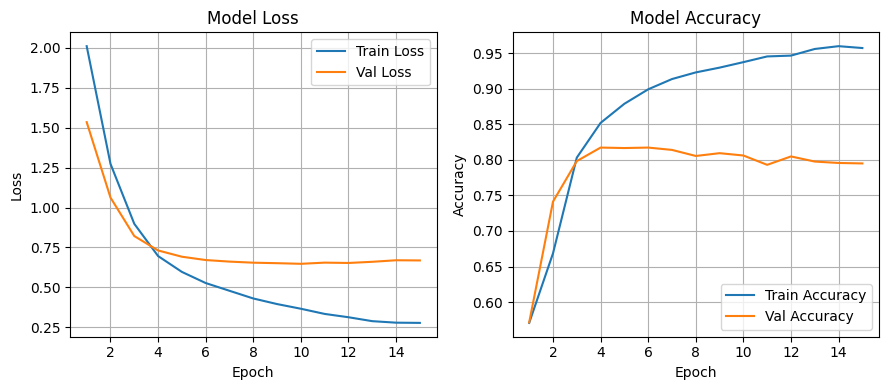

In [53]:
plot_model_history(rnn_tuner_model_history)

From above plot, we can see that both the training loss and validation loss are now smoother, so our tuning parameters are about right. Still, the validation accuracy increases significantly at first but then flattens out and shows little to no further improvement. The optimal number of traning epoch is 20.

**Classification Report & Confusion Matrix**

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Classification Report:
              precision    recall  f1-score   support

Not Disaster       0.80      0.91      0.85       869
    Disaster       0.85      0.70      0.77       654

    accuracy                           0.82      1523
   macro avg       0.83      0.80      0.81      1523
weighted avg       0.82      0.82      0.81      1523



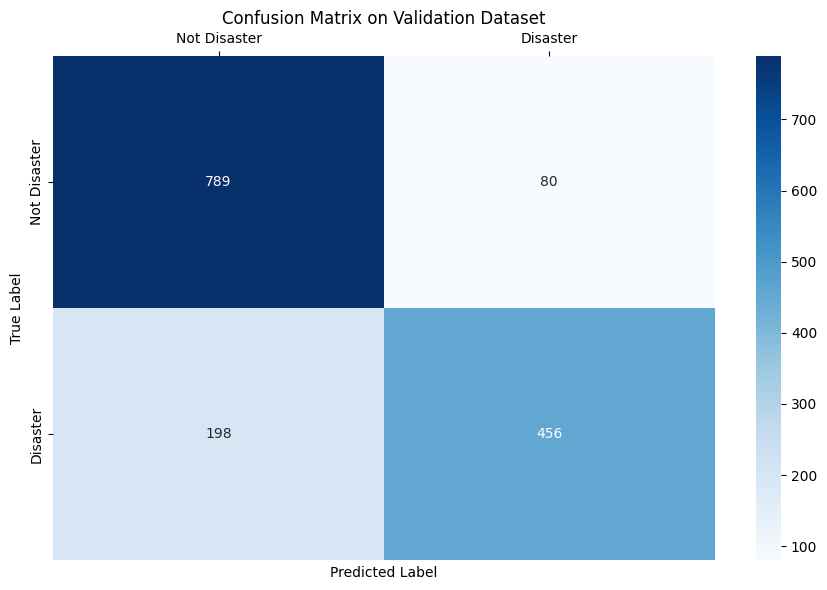

In [54]:
rnn_tuner_model = models.load_model(f'rnn-tuner.keras')
y_val_prob = rnn_tuner_model.predict(tfds_val, batch_size=BATCH_SIZE, verbose=1)
y_val_pred = (y_val_prob >= 0.5).astype(int).flatten()
print("Classification Report:")
print(classification_report(y_val, y_val_pred, target_names=['Not Disaster', 'Disaster']))
# Plot confusion matrix result
plot_confusion_matrix_result(y_val, y_val_pred, labels=['Not Disaster', 'Disaster'], dataset='Validation')

**Submission & Test Results**

In [55]:
# Create kaggle submission
create_submission(rnn_tuner_model, tfds_test, df_test['id'].values, batch_size=BATCH_SIZE)

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Submission file: submission-rnn-tuner.csv

Sample of submission content:
   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1


Kaggle Public Score: 0.79221

In [56]:
# Collect model performance data
performance_data['model'].append('Tuning RNN')
performance_data['train_time'].append(int(time1))
performance_data['train_epoch'].append(len(rnn_tuner_model_history.epoch))
performance_data['val_accuracy'].append(accuracy_score(y_val, y_val_pred))
performance_data['val_f1_score'].append(f1_score(y_val, y_val_pred))

### 3.6. Performance Comparison

In [59]:
# Kaggle public score
performance_data['test_score'] = [0.76984, 0.78547, 0.79619, 0.79221]
# Display performance data
performance_df = pd.DataFrame(performance_data)
print(performance_df)

        model  train_time  train_epoch  val_accuracy  val_f1_score  test_score
0  Simple RNN         122            8      0.815496      0.760851     0.76984
1         GRU          18            9      0.808273      0.759868     0.78547
2        LSTM          32           15      0.808273      0.759868     0.79619
3  Tuning RNN          26           15      0.817466      0.766387     0.79221


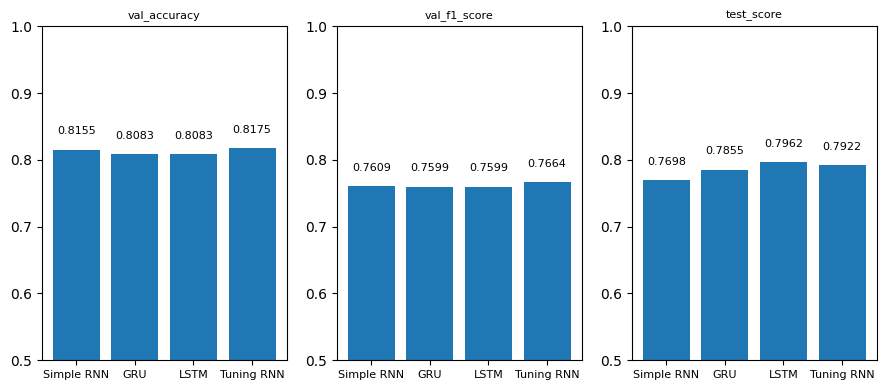

In [60]:
# Plot model comparisions
plt.figure(figsize=(9, 4))

metrics = ['val_accuracy', 'val_f1_score', 'test_score']

for i, metric in enumerate(metrics):
    plt.subplot(1, 3, i+1)
    ax = plt.bar(performance_df['model'].values, performance_df[metric])
    for p in ax.patches:
        count = p.get_height()
        ptitle = f'{count:,.04f}'
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        plt.text(x, y + 0.02, ptitle, ha='center', va='bottom', fontsize=8)
    plt.title(metric, fontsize=8)
    plt.xticks(fontsize=8)
    plt.ylim(0.5,1.0)
    
plt.tight_layout()
plt.show()

## 4. Summary

In this project, we explored the Disaster Tweets dataset. We inspected and analyzed keywords, hashtags, mentions, tweet length, etc. We cleaned and processed text, vectorized and transfromed the raw text into sequences, and prepared tensorflow datasets to train and test our models. We built our deep learning models to detect whether a tweet is about a real disaster based on the related keywords and tweet content using recurrent neural networks (RNN). We tried vanilla RNN, Gated Recurrent Unit (GRU) and Long Short-Term Memory (LSTM) models. Finally we used keras_tuner to find the optimal model by tuning the model hyperparameters including: Number of GRU units, Dropout and learning rate. 

Learnings and takeaways:

From the results, we see that LSTM/GRU work much better than basic, vanilla RNN. We were able to improve the test score from 0.7698 to 0.7962. Applying techniques such as early stopping can help shorten training time. However, all models are still struggling with the same issue of overfitting, vanishing gradient. 

Further enhancements: Here are things I would like to try:

- Data Augmentation: I would like to apply data augmentation techniques (such as NLPAug) to address our dataset. As we can see our dataset is slightly imbalanced and it's fairly small. By generating more data from our training dataset, this can help the model generalize better to variations in real-world data. 
- Transfer Learning: Leveraging wellknown powerful pre-trained language models such as BERT (Bidirectional Encoder Representations from Transformers) or it's lighter verion DistilBERT (Distilled Bidirectional Encoder Representations from Transformers").

## 5. Kaggle Public Score

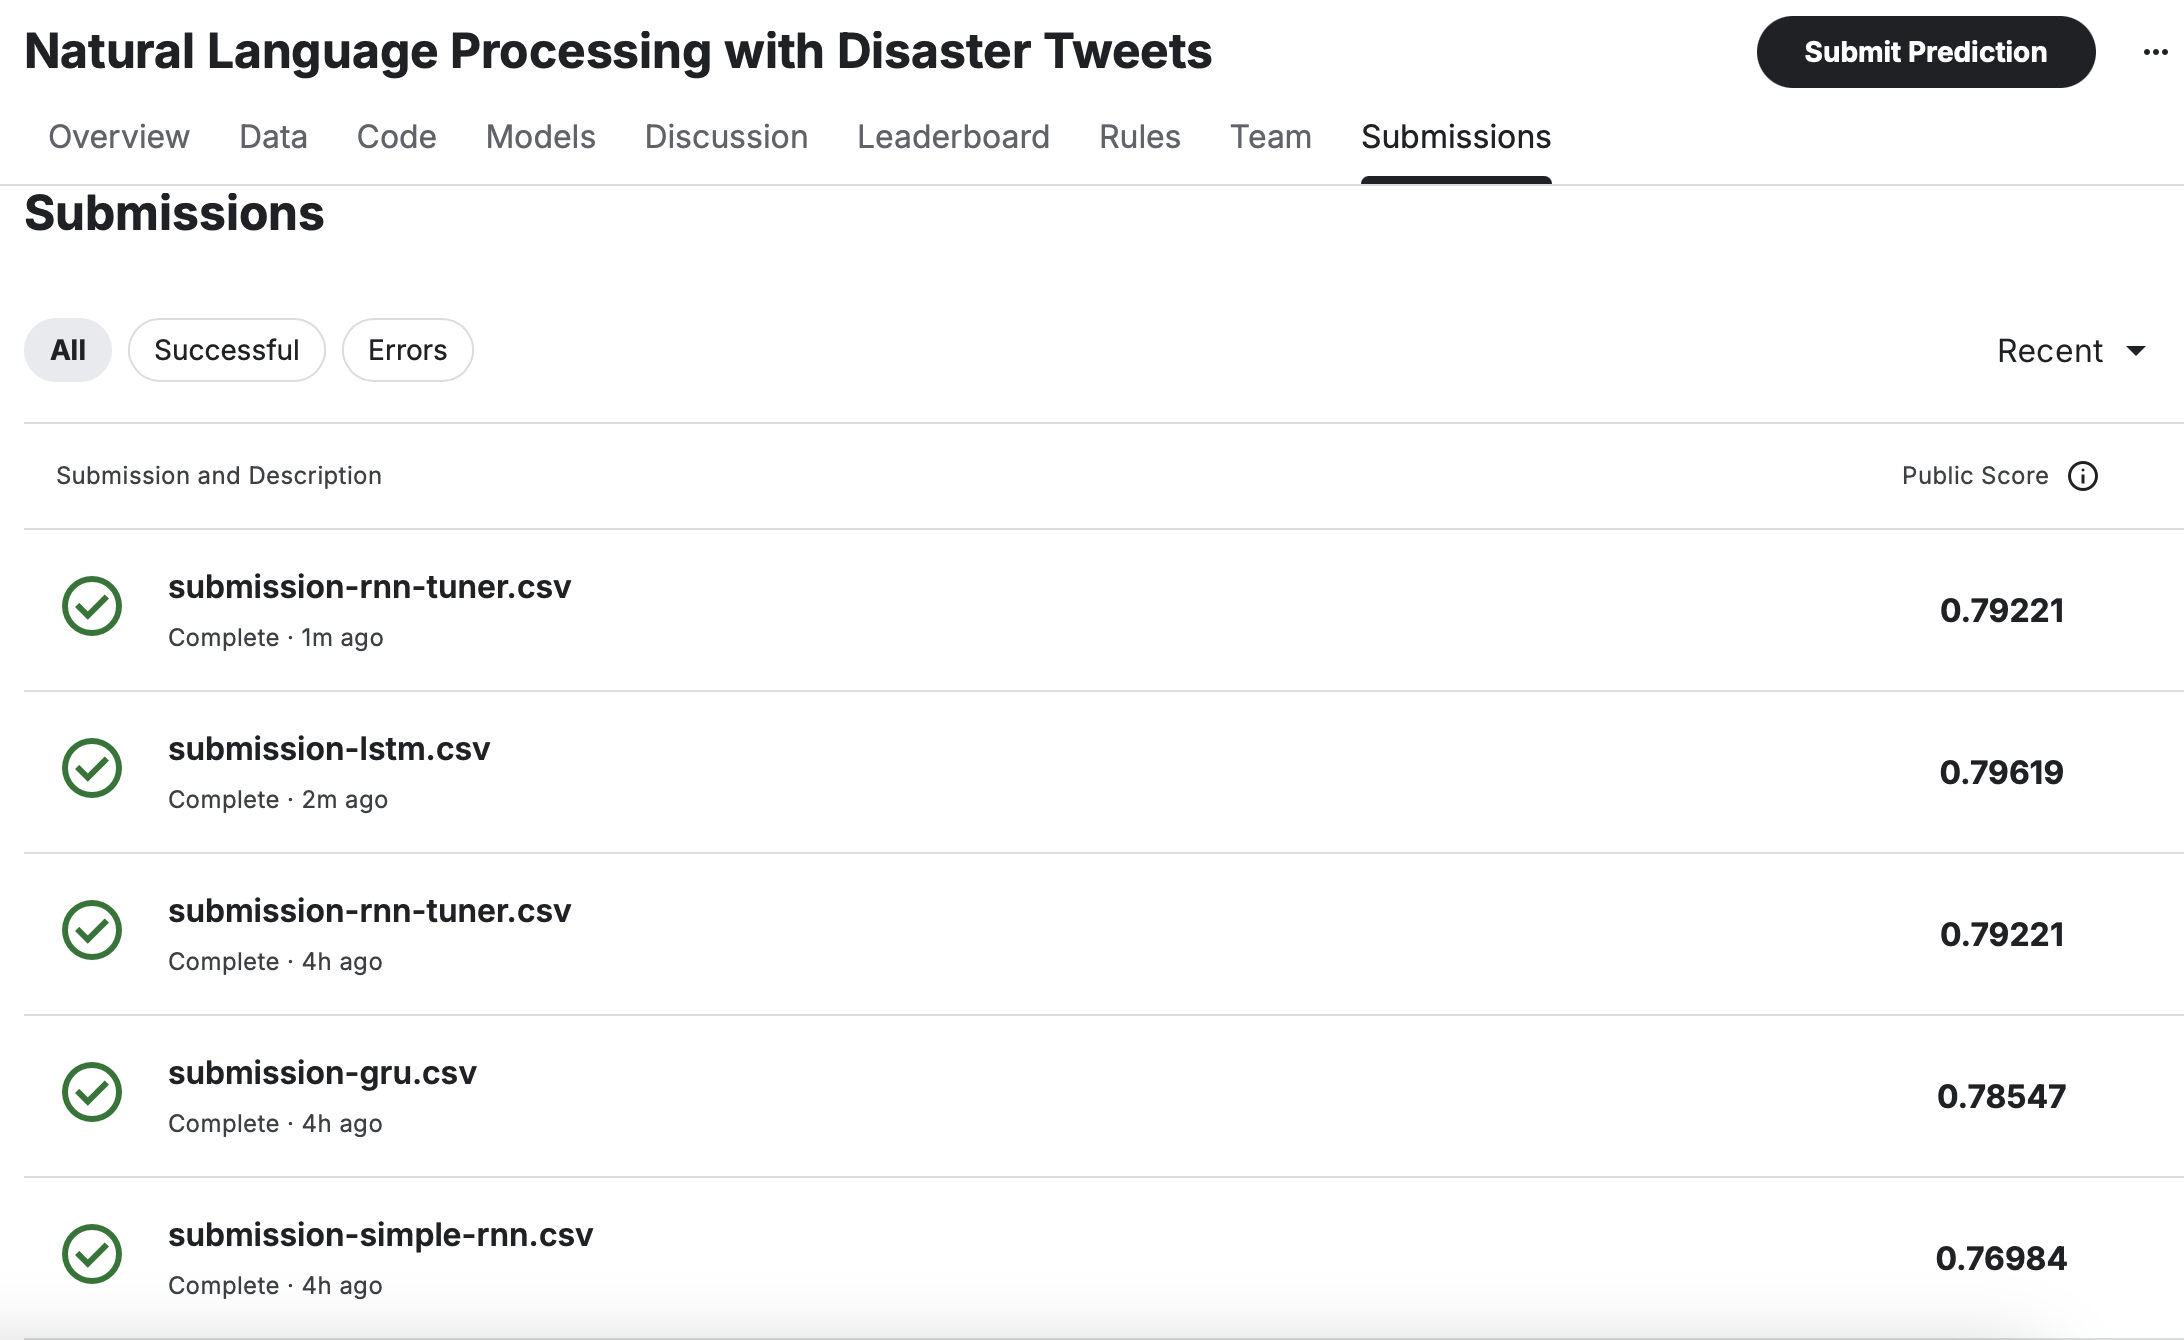

## 5. Project's GitHub Repository

This notebook is available here: [https://github.com/dongndp/nlp-disaster-tweets](https://github.com/dongndp/nlp-disaster-tweets).